# What is this about?
This is a Blog-cum-coding tutorial in Practical Deep Learning. You can start exploring this notebook directly provided that you already have some basic understanding of Deep Learning and Pytorch implementation.\
I feel like almost everyone has gone through some introductory tutorial where they will utilize some inbuilt MNIST like dataset and work some simple 2 layer model. But in practice, DL is rarely so simple and often gets messy.\
I will walk you through some ways to boost performance, as well as some things such as interpreting the algotihms. This will be a constant WIP, I will keep adding more material. \
Reach out to me on pgujarat@iu.edu for suggestions, feedback and doubts.

## Before you begin
* This notebook can be used in the raw .ipynb format, or directly used on Google Colab. The latter is recommended since the instructions to load and use data are meant for Google Colab use.
* Make sure you select the google colab 'GPU' option, and clone this notebook.
* We will be using a donkey car dataset which you can download [here](https://drive.google.com/file/d/1H3BZqnb7VACDXS8e8hcSEQCNouaSnglj/view?usp=sharing)


In [ ]:
#only use for Google colab
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Installing Libraries
It is suggested that you should restart the runtime after installing these libraries, to avoid errors. You do not need to remount Google drive after restarting runtime. Go to Runtime -> Restart Runtime.

In [ ]:
%%shell
pip install imagecorruptions hyperopt captum --quiet
pip install --ignore-installed imgaug --quiet
pip uninstall -y Pillow --quiet
pip install Pillow==5.3.0 --quiet

     |████████████████████████████████| 2.1MB 2.6MB/s 
     |████████████████████████████████| 952kB 2.7MB/s 
     |████████████████████████████████| 25.9MB 117kB/s 
     |████████████████████████████████| 49.5MB 63kB/s 
     |████████████████████████████████| 1.0MB 58.8MB/s 
     |████████████████████████████████| 2.2MB 78.8MB/s 
     |████████████████████████████████| 14.5MB 240kB/s 
     |████████████████████████████████| 11.6MB 75.5MB/s 
     |████████████████████████████████| 12.4MB 57.1MB/s 
     |████████████████████████████████| 3.3MB 49.4MB/s 
     |████████████████████████████████| 163kB 58.6MB/s 
     |████████████████████████████████| 1.1MB 54.4MB/s 
     |████████████████████████████████| 71kB 10.2MB/s 
     |████████████████████████████████| 235kB 73.4MB/s 
     |████████████████████████████████| 4.4MB 57.0MB/s 
     |████████████████████████████████| 1.6MB 61.2MB/s 
     |████████████████████████████████| 153kB 63.9MB/s 
ERROR: tensorflow 2.3.0 has requirement numpy<1.19

In [ ]:
import numpy as np
import pandas as pd
import random
import pickle
from PIL import Image
import matplotlib.pyplot as plt
import seaborn as sns
import os
import warnings
import itertools 
from sklearn.metrics import *
from sklearn.model_selection import train_test_split 
warnings.filterwarnings('ignore')
import time
%matplotlib inline

#Importing pytorch functions and modules
import torch
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(torch.cuda.get_device_name(0))
import torch.nn as nn
import torch.nn.functional as F
from torch import optim
import torch.utils.data
from torch.utils.data import Dataset, DataLoader
import torch.utils.data as Data
from torchvision import models,transforms
import zipfile

from sklearn.metrics import *

SEED = 1234
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

torch.manual_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)


from collections import OrderedDict
from hyperopt import fmin, tpe, hp, STATUS_OK

Tesla P100-PCIE-16GB


# Data pre-processing
### What is the donkey car dataset?
The dataset is made manually from a simple car-driving game simulator, which means the quality of the output is only as good as my driving. You can make your own dataset too using this [simulator](https://docs.donkeycar.com/guide/simulator/) .The input is the image observed in each frame, and the target is the navigation input by user( left turn, right turn, acceleration, etc). The objective thus, is to train a car how to drive. Although this is not a biomedical dataset, it is a good example of how real world datasets are - they are unclean, in weird formats, they have imblanced proportion of output, which we shall see going ahead. \



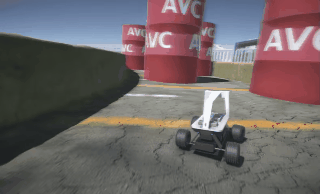

In [ ]:
#Extracting the dataset
root_dir = "drive/My Drive/INFO-590 course materials/"   #this is the directory where your donkey_car_dataset.zip file is, please change this to where you downloaded file ( the 'drive/My Drive' part will be as is for Colab)
if('donkey_car_dataset' not in os.listdir(root_dir)):
  with zipfile.ZipFile(os.path.join(root_dir,"donkey_car_dataset.zip"),"r") as zip_ref:
      zip_ref.extractall(root_dir)

In [ ]:
#looking at the dataset size and distribution
data_df = pd.read_csv(os.path.join(root_dir,"donkey_car_dataset.csv"))
data_df.head()

record      json_file  ... angle  nav
0       0  record_0.json  ...     0    1
1       1  record_1.json  ...     0    1
2       2  record_2.json  ...     0    1
3       3  record_3.json  ...     0    1
4       4  record_4.json  ...     0    1

[5 rows x 10 columns]

In [ ]:
data_df.shape

(9861, 10)

In [ ]:
#basically our output/target 'nav' is made from combination of throttle and angle field
data_df[["throttle","angle","nav"]].drop_duplicates()  #throttle = 1 means accelerate, angle = +1 mean right and angle = -1 means left. Accordingly there are 6 combinations for navigation

throttle  angle  nav
0            0      0    1
22           1      0    4
211          1      1    5
373          1     -1    3
1282         0     -1    0
1675         0      1    2

In [ ]:
#What does the distribution tell you?
data_df["nav"].value_counts()

4    5104
3    1445
5    1286
1    1220
0     497
2     309
Name: nav, dtype: int64

## Data imbalance
* As we see the proportion of different classes in the target is different. This is often the case in actual datasets, hence stratification is important. 'Stratification' is making sure the proportion remains constant in both train and validation datasets.
* Another point to note is the evaluation metric. Say 10% of any population has COVID and we are training a model which looks at peopls' lung scans to predict if a patient will test negative or not. This is an example of imbalanced data. We fit a weak classifier, which predicts no one tests positive. What will be your accuracy? 90%? Sounds impressive but it is misleading since your model actually ends up not working at all. Hence we need to look at some better way to evaluate performance of our models - 


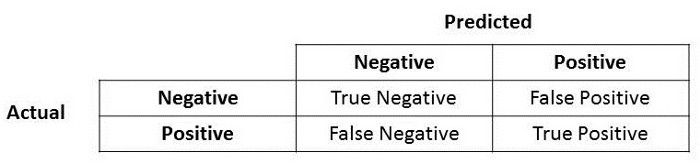

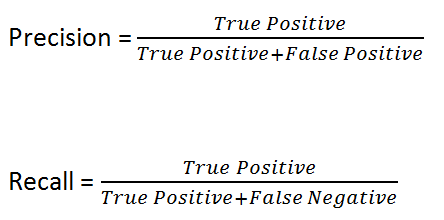

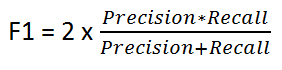

* Precision is used when we only want to look at the prediction and whether the positive predictions are well or not, and the negative predictions do not matter. Also False positives are costly.
* Recall is used when we want to cast a wider net and make sure every example that is actually positive is predicted as positive and false positives are managable. Predicting COVID is one such example, false positves do not hurt but false negatives are way more dangerous.
* F1 score is a balance between both Precision and recall, and is the HM of the two , so it will be 0 if either Precision or Recall is zero.

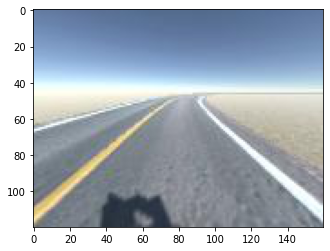

In [ ]:
#let us read and visualize a single image (We use PIL library for opening images)
img_name = data_df["image_file"].values[0]
img_dir = os.path.join(root_dir,"donkey_car_dataset/")
img = Image.open(os.path.join(img_dir,img_name))    #we can simply open an image using Image.open(image_path)
plt.imshow(img)

In [ ]:
#we can convert this PIL image format to numpy array. 
print(type(img))
img_arr = np.array(img)
print(type(img_arr))

<class 'PIL.JpegImagePlugin.JpegImageFile'>
<class 'numpy.ndarray'>


In [ ]:
print(img_arr.shape)

(120, 160, 3)


## How to load large datasets
As we can see, each image is RGB with shape 160x120. The total shape of the input is 9861x3x160x120. We can easily exceed the RAM by putting this all in one large variable. Keep in mind real world dataset are even much larger than this having tens of thousands of images. Also, for this dataset, the labels and the images are not present together( labels are present in dataframe). Since we shuffle when making mini batches, we have to be careful that these labels and images match after loading into batches \
The proper way of doing this is to use Pytorch Dataset Class, which also also allows to match images vs labels, besides we can also apply transformations to images while utilizing parallel processing to make things faster.

In [ ]:
#here we define a small class that reads a dataset, all we need to define is a function __len__ that gets the length of the dataset, and __getitem__ which gets us one single item.
#This format remains constant for a data ingestion class, which can be directly used to for creating mini batches for the data loaders functions.
class DonkeyCarDataset(Dataset):
    def __init__(self, data_df,img_col,label_col,img_dir,transform=None):
        """
        Args:
            data_df: dataframe with filenames and other things
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.data_df = data_df         #input dataframe
        self.transform = transform     #transformation on the input
        self.img_col = img_col       #column which has the images
        self.label_col = label_col   #column which has the labels
        self.img_dir = img_dir       #home directory of images

    def __len__(self):
        return len(self.data_df)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir,self.data_df[self.img_col].values[idx])    #fetching image corresponding to index idx
        input = self.transform(Image.open(img_path))                                      #reading and transforming image
        target = self.data_df[self.label_col].values[idx]                              #reading corresponding labels
        return(input,target)

# for a new dataset, simply replace the function as per your dataset, so you can apply transforms, reshaping, any preprocessing of data within this function itself.

In [ ]:
#let us first divide into train and validation datasets. We simply apply this to our dataframe
train_df,val_df = train_test_split(data_df,test_size=0.2,stratify=data_df["nav"].values,random_state=SEED)


#defining transformations on input images(these directly take PIL image as input)
transform = transforms.Compose([transforms.Resize(size=[120,160]),
                                transforms.ToTensor(),
                                transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                                      std=[0.229, 0.224, 0.225]
                                                      )])

#we then create dataset objects
trainset = DonkeyCarDataset(data_df=train_df,
                            label_col="nav",
                            img_col="image_file",
                            img_dir=img_dir,
                            transform=transform)
valset = DonkeyCarDataset(data_df=val_df,
                            label_col="nav",
                            img_col="image_file",
                            img_dir=img_dir,
                            transform=transform)


# Simple CNN and setting baseline and observing performance
Please note that for every cnn block, we have the activation function, the pooling layer, the batch norm layer, the dropout  in that sequence

In [ ]:
Network2d = nn.Sequential(#first convolutional block
                      nn.Conv2d(in_channels=3,                                                                   
                               out_channels=8,                                                 
                               kernel_size=[24,32],                                           
                               stride=1), #cnn layer                                           
                      nn.ReLU(), #relu                                                         
                      nn.MaxPool2d(kernel_size=[2,2]),#max pooling                             
                      nn.BatchNorm2d(8), #batch-norm                                           
                      nn.Dropout(0.2),                                                         
                      #second convolutional block
                      nn.Conv2d(in_channels=8,
                                out_channels=8,
                                kernel_size=[6,8],
                                stride=2),
                      nn.MaxPool2d(kernel_size=[2,2]),
                      nn.BatchNorm2d(8),
                      nn.Dropout(0.2),
                      #linear (fully connected) layers
                      nn.Flatten(start_dim=1),  #flatten to (examples,dim) shape from (examples,k,h,w)
                      nn.Linear(1232,1024),
                      nn.ReLU(),
                      nn.BatchNorm1d(1024),
                      nn.Dropout(0.2),
                      nn.Linear(1024,256),
                      nn.ReLU(),
                      nn.BatchNorm1d(256),
                      nn.Dropout(0.2),
                      nn.Linear(256,6)         #output layer
                      )

model = Network2d().to(device)



keep in mind, the above is the 'short-cut' way of defining neural network, we need to keep in mind the long way for future tasks. Here is the longer way of the same network, commented out.

In [ ]:

# class Network2d(nn.Module):
#     def __init__(
#             self,
#             dropout=0.2
#     ):
#         super(Network2d, self).__init__()
#         self.dt = nn.Dropout(dropout)
#         self.relu = nn.ReLU()


#         self.conv1 = nn.Conv2d(in_channels=3,
#                                out_channels=8,
#                                kernel_size=[24,32],
#                                stride=1)
#         self.maxp1 = nn.MaxPool2d(kernel_size=[2,2])
#         self.bn1 = nn.BatchNorm2d(8)

#         self.conv2 = nn.Conv2d(in_channels=8,
#                 out_channels=8,
#                 kernel_size=[6,8],
#                 stride=2)
#         self.maxp2 = nn.MaxPool2d(kernel_size=[2,2])
#         self.bn2 = nn.BatchNorm2d(8)

#         self.fc1 = nn.Linear(1232,1024)
#         self.bn3 = nn.BatchNorm1d(1024)
#         self.fc2 = nn.Linear(1024,256)
#         self.bn4 = nn.BatchNorm1d(256)
#         self.fc3 = nn.Linear(256,6)
#         self.bn5 = nn.BatchNorm1d(6)
        
#     def forward(self,x): 

#         #Two convolutional blocks   
#         x = self.conv1(x)
#         x = self.relu(x)
#         x = self.maxp1(x)
#         x = self.bn1(x)
#         x = self.dt(x)

#         x = self.conv2(x)
#         x = self.relu(x)
#         x = self.maxp2(x)
#         x = self.bn2(x)
#         x = self.dt(x)
        
#         #flattening 2d to 1d
#         x = torch.flatten(x, start_dim=1)
        
#         x = self.fc1(x)
#         x = self.relu(x)
#         x = self.bn3(x)
#         x = self.dt(x)

#         x = self.fc2(x)
#         x = self.relu(x)
#         x = self.bn4(x)
#         x = self.dt(x)

#         x = self.fc3(x)
#         x = self.relu(x)
#         x = self.bn5(x)
#         x = self.dt(x)
#         return(x)
# model = Network2d().to(device)

## Defining training loop
We define a standard function to train our model since we will use this again. Since we are not aware when the overfitting begins, what we can do is a 'while' loop. The model will train for a maximum number of epochs, but if validation loss doesn't decrease after simulataneously for a few epochs, we stop training. This is also known as 'early stopping'. \
I realize this is a long piece of code, but it is better to write long but flexible code once than small code repeatedly. We will train different versions of this model again, so we won't need to write the whole again, instead just call this function. \

In [ ]:
def train_model(model,trainset,valset,max_epochs,learning_rate=0.001,batch_size=500,early_stopping_rounds=5,verbose=True):

  #Defining data loaders
  train_loader = DataLoader(trainset,     
                          batch_size=batch_size,
                          shuffle=True,
                          num_workers=4)           #this helps us complete the processes in the Dataset class parallelly accross cores of our CPU

  val_loader = DataLoader(valset,     
                          batch_size=batch_size,
                          shuffle=True,
                          num_workers=4)  
  
  #defining loss function and optimizers
  criterion = nn.CrossEntropyLoss().to(device)
  optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
  best_score = 0.0
  stop = False
  epoch = 0
  torch.cuda.empty_cache()   #this clears cache from GPU, making things slightly fasters and avoiding overflow of GPU RAM. It is optional but recommended.

  #main while loop for training
  while ((epoch<max_epochs)&(stop==False)):   
    if(verbose==True):print("*******EPOCH:{}*******".format(epoch+1))

    train_loss_arr= []   #storing the loss for every mini-batch
    val_loss_arr = []    #storing the validation loss for every epoch
    for x,y in train_loader:   # we will iterate through every mini batch in 1 epoch
      x_train = x.to(device)    #transfering to GPU
      y_train = y.to(device)
      y_train_pred = model.train().forward(x_train)   
      loss = criterion(y_train_pred,y_train)   #calculating loss   
      optimizer.zero_grad()   
      loss.backward()   #updating gradients  
      train_loss_arr.append(loss.item()*x_train.shape[0])  #recording total loss of mini batch by multiplying average loss by mini batch length ( recall that by default, cost_function calculats average loss per sample)
      optimizer.step()    
    train_loss = np.sum(train_loss_arr)/train_df.shape[0]    #taking overall average of loss
    torch.cuda.empty_cache()

    if(verbose==True):print("training loss : {}".format(round(train_loss,3)))

    val_pred_arr = []
    val_true_arr = []
    val_loss_arr = []
    for x,y in val_loader:
      with torch.no_grad():    #if we are only doing prediction, and do not need gradients calculated, we can use this for saving computation 
        x_val = x.to(device)
        y_val = y.to(device)
        y_val_pred = model.eval().forward(x_val)   #forward propagation ( note how we use model.eval())
        val_pred_arr += list(torch.argmax(y_val_pred,dim=1).detach().cpu().numpy())    #detaching, bringing to cpu and converting to numpy
        val_true_arr += list(y_val.detach().cpu().numpy())    #detaching, bringing to cpu and converting to numpy
        loss_val = criterion(y_val_pred,y_val)   
        val_loss_arr.append(loss_val.item()*x_val.shape[0])     #recording sum of validation loss
        
    val_loss = np.sum(val_loss_arr)/val_df.shape[0]
    Y_val = np.array(val_true_arr).reshape(-1)         #flattening so we have single length array
    Y_val_pred = np.array(val_pred_arr).reshape(-1)         #flattening so we have single length array
    f1 = f1_score(Y_val,Y_val_pred,average='macro') #calculating f1 score 
    accuracy = accuracy_score(Y_val,Y_val_pred)
    if(verbose==True):print("validation loss :{0:.3f}, accuracy : {1:.3f} and f1_score : {2:.3f}".format(val_loss,accuracy,f1))   #printing validation loss ( rounded to 3 decimals)

    if(f1>best_score):                    #we compare if performance has improved, if not we stop training. Please note instead of performance, we can alos check for if loss has reduced or not.
      best_score = f1
      best_state = model.state_dict()
      rounds = 0
    else:
      rounds +=1
      if(rounds>=early_stopping_rounds):      #early stopping condition fulfilled, stopping 
        stop = True
        if(verbose==True):print(" ...stopped training")
    epoch +=1
    #end of while loop (phew!)
  #deleting these variables helps create some space
  del(train_loader)
  del(val_loader)
  
  return(best_state,best_score)

In [ ]:
t0 = time.time()
best_state,f1 = train_model(model = model,
                            trainset=trainset,
                            valset=valset,
                            max_epochs = 100,
                            batch_size=500,
                            learning_rate = 0.001,
                            early_stopping_rounds=5)
print("time taken for convergence(minutes) : {0:.3f}".format((time.time()-t0)/60))

*******EPOCH:1*******
training loss : 1.436
validation loss :0.983, accuracy : 0.642 and f1_score : 0.463
*******EPOCH:2*******
training loss : 0.993
validation loss :0.866, accuracy : 0.678 and f1_score : 0.587
*******EPOCH:3*******
training loss : 0.795
validation loss :1.779, accuracy : 0.414 and f1_score : 0.368
*******EPOCH:4*******
training loss : 0.692
validation loss :0.699, accuracy : 0.737 and f1_score : 0.679
*******EPOCH:5*******
training loss : 0.611
validation loss :0.748, accuracy : 0.718 and f1_score : 0.660
*******EPOCH:6*******
training loss : 0.543
validation loss :0.776, accuracy : 0.706 and f1_score : 0.590
*******EPOCH:7*******
training loss : 0.503
validation loss :0.526, accuracy : 0.780 and f1_score : 0.730
*******EPOCH:8*******
training loss : 0.469
validation loss :0.457, accuracy : 0.807 and f1_score : 0.774
*******EPOCH:9*******
training loss : 0.434
validation loss :0.479, accuracy : 0.805 and f1_score : 0.769
*******EPOCH:10*******
training loss : 0.401
v

# Tips and tricks to improve performance
Keep a note of what is the best score achieved in previous section, we will aim to improve over this. How much of an improvement do you feel is possible?

## Transfer Learning
Transfer learning is a technique where you can use a neural network trained to solve a particular type of problem and with a few changes, you can reuse it to solve a related problem. For example, if you want to develop a model to distinguish between cars and trucks, it’s a great solution to use a network trained with ImageNet contest, and apply transfer learning to fine-tune the network to accomplish your task. \
With this technique learning process can be faster, more accurate and need less training data, in fact, the size of the dataset and the similarity with the original dataset (the one in which the network was initially trained) are the two keys to consider before applying transfer learning. 'Freezing' the parameters of a neural network means making them impervious to backpropagation and treating them as complete constants. Sometimes we partially freeze a neural network if that part of the network has already learned what we need it to learn. There are various ways to use transfer learning :
* Case 1 : Load the pre-trained model, and used the learnt weights as starting point and fine tune them further. This is most costly and difficult to achieve without industrial level computation. Basically you need hundreds of GPUs or you need to be Google. Pre trained models can have upto 150 total layers.
* Case 2: Freeze paramters of the pre-trained model, and add some linear layers at the end which are learnable. However, this assumes the pre-trained model can extract all the features you need for modeling.
* Case 3: Use the original network as an augmented features. So We take this last layer  of pre-trained model as extra 'features' and concatenate them along with the linear layer of our pre-existing model. This will speed up the learning without costing too much computation and may even boost the final performance. \


In [ ]:
#let us look at the resnet pre-trained model 
resnet = models.resnet18(pretrained=True)

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/hub/checkpoints/resnet18-5c106cde.pth


In [ ]:
sample_images = torch.randn(10,3,120,160)                    #10 random sample images
sample_output = resnet.eval()(sample_images)                 #output of samples
sample_output.shape                                          # we get output of linear layer of size 1000! (We can also refer to these as 1000 'extra features')

torch.Size([10, 1000])

Let us look at the examples of using transfer learning for case 2 and 3.

In [ ]:
#Case 2 transfer learning.
class Network_Case2(nn.Module):
    def __init__(
            self,
            dropout=0.2
    ):
        super(Network_Case2, self).__init__()
        # we will refer to pre-trained model as extractor
        self.extractor = models.resnet18(pretrained=True).to(device)
        #freezing parameters of extractor (comment out this part to try case 1)
        for param in self.extractor.parameters():
          param.requires_grad = False

        self.fc1 = nn.Linear(1000,64)
        self.relu = nn.ReLU()
        self.bn1 = nn.BatchNorm1d(64)
        self.dt = nn.Dropout(dropout)
        self.fc2 = nn.Linear(64,6)
        
        
    def forward(self,x): 
        x = self.extractor(x)

        x = self.fc1(x)
        x = self.relu(x)
        x = self.bn1(x)
        x = self.dt(x)

        x = self.fc2(x)
        return(x)
model_case2 = Network_Case2().to(device)

In [ ]:
t0 = time.time()
best_state,f1 = train_model(model = model_case2,
                            trainset=trainset,
                            valset=valset,
                            max_epochs = 100,
                            batch_size = 500,
                            learning_rate = 0.001,
                            early_stopping_rounds=5)
print("time taken for convergence(minutes) : {0:.3f}".format((time.time()-t0)/60))

*******EPOCH:1*******
training loss : 1.559
validation loss :1.275, accuracy : 0.567 and f1_score : 0.421
*******EPOCH:2*******
training loss : 1.248
validation loss :1.118, accuracy : 0.655 and f1_score : 0.571
*******EPOCH:3*******
training loss : 1.088
validation loss :1.041, accuracy : 0.687 and f1_score : 0.615
*******EPOCH:4*******
training loss : 0.97
validation loss :0.949, accuracy : 0.701 and f1_score : 0.626
*******EPOCH:5*******
training loss : 0.871
validation loss :0.874, accuracy : 0.718 and f1_score : 0.651
*******EPOCH:6*******
training loss : 0.778
validation loss :0.835, accuracy : 0.722 and f1_score : 0.651
*******EPOCH:7*******
training loss : 0.703
validation loss :0.773, accuracy : 0.733 and f1_score : 0.663
*******EPOCH:8*******
training loss : 0.648
validation loss :0.747, accuracy : 0.743 and f1_score : 0.688
*******EPOCH:9*******
training loss : 0.607
validation loss :0.716, accuracy : 0.756 and f1_score : 0.706
*******EPOCH:10*******
training loss : 0.553
va

We see performance is not quite up to par with the model trained from scratch, although time taken is lesser. Now let's look at the Case 3 approach.

In [ ]:
#Case 3 transfer learning model
class Network_Case3(nn.Module):
    def __init__(
            self,
            dropout=0.2
    ):
        super(Network_Case3, self).__init__()

        self.extractor = models.resnet18(pretrained=True).to(device)
        for param in self.extractor.parameters():
          param.requires_grad = False


        self.dt = nn.Dropout(dropout)
        self.relu = nn.ReLU()



        self.conv1 = nn.Conv2d(in_channels=3,
                               out_channels=8,
                               kernel_size=[24,32],
                               stride=1)
        self.maxp1 = nn.MaxPool2d(kernel_size=[2,2])
        self.bn1 = nn.BatchNorm2d(8)

        self.conv2 = nn.Conv2d(in_channels=8,
                out_channels=8,
                kernel_size=[6,8],
                stride=2)
        self.maxp2 = nn.MaxPool2d(kernel_size=[2,2])
        self.bn2 = nn.BatchNorm2d(8)

        self.fc1 = nn.Linear(2232,1024)           #note than instead of 1232, we are having 1232 +1000 = 2232 input features for linear layer since this is where we are concatenating output of extractor  
        self.bn3 = nn.BatchNorm1d(1024)
        self.fc2 = nn.Linear(1024,256)                      
        self.bn4 = nn.BatchNorm1d(256)
        self.fc3 = nn.Linear(256,6)
        self.bn5 = nn.BatchNorm1d(6)
        
    def forward(self,x): 

        #output of extractor
        x_extractor = self.extractor(x)

        #Two convolutional blocks   
        x = self.conv1(x)
        x = self.relu(x)
        x = self.maxp1(x)
        x = self.bn1(x)
        x = self.dt(x)

        x = self.conv2(x)
        x = self.relu(x)
        x = self.maxp2(x)
        x = self.bn2(x)
        x = self.dt(x)
        
        #flattening 2d to 1d
        x = torch.flatten(x, start_dim=1)
        #concatenating putput of extractor
        x = torch.cat([x,x_extractor],dim=1)
        
        x = self.fc1(x)
        x = self.relu(x)
        x = self.bn3(x)
        x = self.dt(x)

        x = self.fc2(x)
        x = self.relu(x)
        x = self.bn4(x)
        x = self.dt(x)

        x = self.fc3(x)
        x = self.relu(x)
        x = self.bn5(x)
        x = self.dt(x)
        return(x)

model_case3 = Network_Case3().to(device)


In [ ]:
t0 = time.time()
best_state,f1 = train_model(model = model_case3,
                            trainset=trainset,
                            valset=valset,
                            max_epochs = 100,
                            batch_size = 500,
                            learning_rate = 0.001,
                            early_stopping_rounds=5)
print("time taken for convergence(minutes) : {0:.3f}".format((time.time()-t0)/60))

*******EPOCH:1*******
training loss : 1.625
validation loss :1.263, accuracy : 0.617 and f1_score : 0.489
*******EPOCH:2*******
training loss : 1.28
validation loss :1.000, accuracy : 0.711 and f1_score : 0.659
*******EPOCH:3*******
training loss : 1.139
validation loss :1.022, accuracy : 0.708 and f1_score : 0.688
*******EPOCH:4*******
training loss : 1.017
validation loss :0.950, accuracy : 0.752 and f1_score : 0.729
*******EPOCH:5*******
training loss : 0.952
validation loss :0.922, accuracy : 0.769 and f1_score : 0.756
*******EPOCH:6*******
training loss : 0.888
validation loss :0.814, accuracy : 0.830 and f1_score : 0.805
*******EPOCH:7*******
training loss : 0.838
validation loss :0.891, accuracy : 0.763 and f1_score : 0.760
*******EPOCH:8*******
training loss : 0.791
validation loss :0.782, accuracy : 0.832 and f1_score : 0.810
*******EPOCH:9*******
training loss : 0.745
validation loss :0.750, accuracy : 0.837 and f1_score : 0.836
*******EPOCH:10*******
training loss : 0.704
va

## Hyper-parameter tuning
As we discussed earlier, Neural Network training uses various hyper-paramters that determine the eventual performance as well as how fast a model converges. We want the best possbile performance, and if it is the same  for two settings, we want time taken as a tie breaker. \
One way of finding the best hyper-parameters is to do Grid-Search, ie, brute force search of all possible combinations until the best is found. This is called as Grid-Search and as expected is the slowest way of hyper-paramter search.Another route is to use specialized algorithms such as Bayesian Optimization which find hyper-paramters by doing some random searches followed by some focused searches to estimate of the best parameters in ust a few iterations. We will be using a library called Hyper-Opt for hyper paramter tuning, and finding the best parameters

In [ ]:
#redefining the original network. 
class Network2d(nn.Module):
    def __init__(
            self,
            dropout=0.2
    ):
        super(Network2d, self).__init__()
        self.dt = nn.Dropout(dropout)
        self.relu = nn.ReLU()      


        self.conv1 = nn.Conv2d(in_channels=3,
                               out_channels=8,
                               kernel_size=[24,32],
                               stride=1)
        self.maxp1 = nn.MaxPool2d(kernel_size=[2,2])
        self.bn1 = nn.BatchNorm2d(8)

        self.conv2 = nn.Conv2d(in_channels=8,
                out_channels=8,
                kernel_size=[6,8],
                stride=2)
        self.maxp2 = nn.MaxPool2d(kernel_size=[2,2])
        self.bn2 = nn.BatchNorm2d(8)

        self.fc1 = nn.Linear(1232,1024)
        self.bn3 = nn.BatchNorm1d(1024)
        self.fc2 = nn.Linear(1024,256)
        self.bn4 = nn.BatchNorm1d(256)
        self.fc3 = nn.Linear(256,6)
        self.bn5 = nn.BatchNorm1d(6)
        
    def forward(self,x): 

        #Two convolutional blocks   
        x = self.conv1(x)
        x = self.relu(x)
        x = self.maxp1(x)
        x = self.bn1(x)
        x = self.dt(x)

        x = self.conv2(x)
        x = self.relu(x)
        x = self.maxp2(x)
        x = self.bn2(x)
        x = self.dt(x)
        
        #flattening 2d to 1d
        x = torch.flatten(x, start_dim=1)
        
        x = self.fc1(x)
        x = self.relu(x)
        x = self.bn3(x)
        x = self.dt(x)

        x = self.fc2(x)
        x = self.relu(x)
        x = self.bn4(x)
        x = self.dt(x)

        x = self.fc3(x)
        x = self.relu(x)
        x = self.bn5(x)
        x = self.dt(x)
        return(x)

First we define a function that returns to us the final quantity we want to minimize

In [ ]:
def tuning_function(args):            #this function takes in a dictionary of hyper-paramters, and outputs the final score which we want to minimize/maximize
  params = {**args}
  print("**********")
  print(" dropout: {0:.3f} | batch_size : {1} | learning_rate : {2:.4f} ".format(params["dropout"],int(params["batch_size"]),params["learning_rate"]))

  model = Network2d(dropout=params["dropout"]).to(device)
  t0 = time.time()
  _,best_f1 = train_model(model = model,
                            trainset=trainset,
                            valset=valset,
                            max_epochs = 30,             #reducing to 30 since we we have to train multiple iterations
                            batch_size = int(params["batch_size"]),
                            learning_rate = params["learning_rate"],
                            early_stopping_rounds=5,
                            verbose=False)
  best_f1 = round(best_f1,2)
  print("Best F1 score : {}".format(best_f1))
  time_taken_minutes = int((time.time() - t0)/60)
  print("Time taken(minutes) = {}".format(time_taken_minutes))
  #this is the quantity we want to minimize
  final_score = round((1 - best_f1 + 1e-4*time_taken_minutes),4)   #since want minimization, we use (1-f1) and time taken is positive. But we multiply it by 10^-4 since time is only a tie breaker if f1 upto decimals is same
  del(model)           #deleting will clear up some space
  return(final_score)

We then define a paramter space we want to search over.

In [ ]:
param_space = OrderedDict([('batch_size',hp.quniform('batch_size',100,800,100)),           #hp.quniform means distribution over regular intervals( 100,200,300..)
         ('dropout',hp.quniform('dropout',0,0.5,0.1)),
         ('learning_rate',hp.loguniform('learning_rate',np.log(0.0001),np.log(0.01)))])    #loguniform means distribution in exponents( 10^-4,10^-3,10^-2...)

We then proceed to search over the parameter space. Here, paramter space means all possible combinations of batch_size, dropout and learning_rate. 

In [ ]:
best_params = fmin(tuning_function,
    space=param_space,
    algo=tpe.suggest,
    max_evals=10,                       #number of iterations
    verbose=0,
    show_progressbar=False)
print("**********")
print("Best paramters - dropout: {0:.3f} | batch_size : {1} | learning_rate : {2:.4f} ".format(best_params["dropout"],int(best_params["batch_size"]),best_params["learning_rate"]))

**********
 dropout: 0.400 | batch_size : 300 | learning_rate : 0.0002 
Best F1 score : 0.64
Time taken(minutes) = 3
**********
 dropout: 0.400 | batch_size : 200 | learning_rate : 0.0001 
Best F1 score : 0.68
Time taken(minutes) = 4
**********
 dropout: 0.200 | batch_size : 300 | learning_rate : 0.0055 
Best F1 score : 0.75
Time taken(minutes) = 2
**********
 dropout: 0.200 | batch_size : 700 | learning_rate : 0.0018 
Best F1 score : 0.79
Time taken(minutes) = 5
**********
 dropout: 0.100 | batch_size : 700 | learning_rate : 0.0084 
Best F1 score : 0.85
Time taken(minutes) = 6
**********
 dropout: 0.100 | batch_size : 300 | learning_rate : 0.0049 
Best F1 score : 0.88
Time taken(minutes) = 5
**********
 dropout: 0.400 | batch_size : 200 | learning_rate : 0.0002 
Best F1 score : 0.75
Time taken(minutes) = 5
**********
 dropout: 0.400 | batch_size : 400 | learning_rate : 0.0002 
Best F1 score : 0.7
Time taken(minutes) = 5
**********
 dropout: 0.200 | batch_size : 600 | learning_rate : 0

In [ ]:
# best_params = {"dropout":0.2,
#                "batch_size":500,
#                "learning_rate":0.001}

In [ ]:
#now that we have the best paramters, let us train and retrieve the model for it.
model = Network2d(dropout=best_params["dropout"]).to(device)
t0 = time.time()
best_state,best_f1 = train_model(model = model,
                        trainset=trainset,
                        valset=valset,
                        max_epochs = 30,             
                        batch_size = int(best_params["batch_size"]),
                        learning_rate = best_params["learning_rate"],
                        early_stopping_rounds=5,
                        verbose=True)
print("time taken for convergence(minutes) : {0:.3f}".format((time.time()-t0)/60))

*******EPOCH:1*******
training loss : 1.505
validation loss :1.194, accuracy : 0.568 and f1_score : 0.330
*******EPOCH:2*******
training loss : 1.145
validation loss :0.916, accuracy : 0.690 and f1_score : 0.593
*******EPOCH:3*******
training loss : 1.02
validation loss :1.781, accuracy : 0.374 and f1_score : 0.430
*******EPOCH:4*******
training loss : 0.918
validation loss :1.118, accuracy : 0.642 and f1_score : 0.633
*******EPOCH:5*******
training loss : 0.831
validation loss :0.806, accuracy : 0.794 and f1_score : 0.747
*******EPOCH:6*******
training loss : 0.744
validation loss :1.116, accuracy : 0.674 and f1_score : 0.674
*******EPOCH:7*******
training loss : 0.679
validation loss :1.003, accuracy : 0.719 and f1_score : 0.681
*******EPOCH:8*******
training loss : 0.651
validation loss :0.986, accuracy : 0.743 and f1_score : 0.729
*******EPOCH:9*******
training loss : 0.593
validation loss :0.885, accuracy : 0.742 and f1_score : 0.745
*******EPOCH:10*******
training loss : 0.545
va

## Image augmentation
Deep networks need large amount of training data to achieve good performance. To build a powerful image classifier using very little training data, image augmentation is usually required to boost the performance of deep networks. Image augmentation artificially creates training images through different ways of processing or combination of multiple processing, such as random rotation, shifts, shear and flips, etc. \
This not only provides more training data, but also makes our model more robust. In real data, there are often disurbances, the camera shakes, there is dust on the lens and the orientation is not always the same. If our model learns to counter these artifically generated disturbances, it is also better able to adapt to practically occuring disturbances. \
[This Google colab notebook](https://colab.research.google.com/drive/109vu3F1LTzD1gdVV6cho9fKGx7lzbFll#scrollTo=8WJoSAh2qVLw) provides examples of how to implement different augmentation in Pytorch. Keep in mind sometimes, if image rotates, it may not have the same labels. (In the case of Donkey Car dataset, if image is flipped horizontally, navigation target will change).

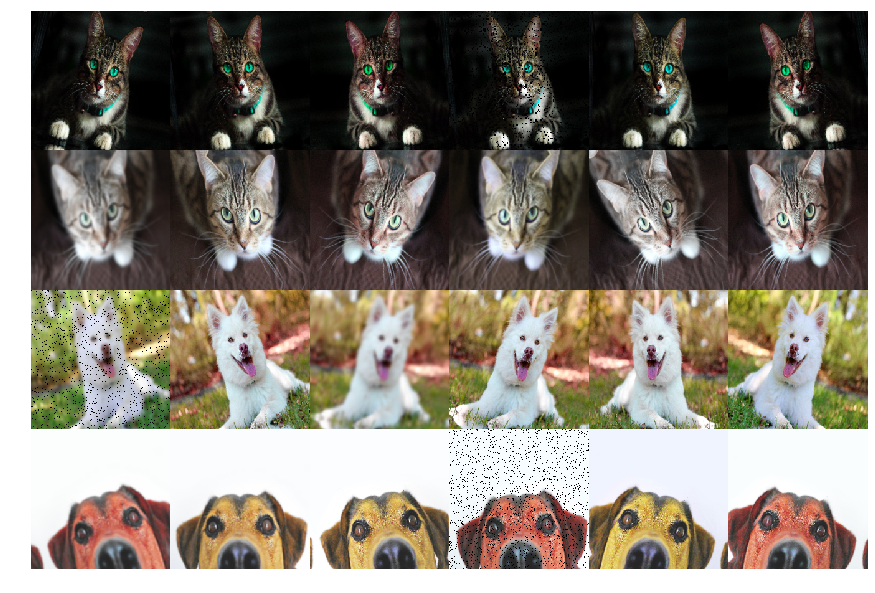

# Explaining and Interpreting DL models
Typically, Neural Networks are black boxes, ie, we do not find out what features the network is using and what portion of image is important. This is essential to understand how a model works. In workplaces and even in research, often one has to explain models to their superior rather than discuss how neural networks work. This improves reliability of the model, and also helps us find out any unwanted bias. (For eg, how do you know if your AI survelliance program is racist or not?)\
To demonstrate, we will use a library called [captum](https://github.com/pytorch/captum), which allows a very simple interface to use various algorithms for Deep Learning interpretation.

In [ ]:
model = Network2d(dropout=best_params["dropout"]).to(device)
model.load_state_dict(best_state)


<All keys matched successfully>

In [ ]:
#sample inputs and baseline
sample_df = train_df.sample(10)
sampleset = DonkeyCarDataset(data_df=sample_df,
                            label_col="nav",
                            img_col="image_file",
                            img_dir=img_dir,
                            transform=transform)
sample_loader = DataLoader(sampleset,     
                        batch_size=10,
                        shuffle=True,
                        num_workers=0)
sample_x,sample_y = next(iter(sample_loader))
sample_x = sample_x.to(device)
sample_y = sample_y.to(device)
baseline = torch.zeros(sample_x.shape).to(device)           #baseline means initialization for the interpretation model


In [ ]:
from captum.attr import (
    GradientShap,
    DeepLift,
    DeepLiftShap,
    IntegratedGradients,
    LayerConductance,
    NeuronConductance,
    NoiseTunnel,
)

#this will be used to scale output
def scale(arr):
  minarr = np.min(arr)
  maxarr = np.max(arr)
  return((arr-minarr)/(maxarr-minarr))

baseline_dist = baseline * 0.001
gs = GradientShap(model)
attributions, delta = gs.attribute(sample_x, stdevs=0.09, n_samples=4, baselines=baseline_dist,
                                   target=3, return_convergence_delta=True)
# ig = IntegratedGradients(model)
# attributions, delta = ig.attribute(sample_x, baseline, target=1, return_convergence_delta=True)

img = sample_x[0].transpose(0,2).transpose(0,1).cpu().numpy()
attr = attributions[0].transpose(0,2).transpose(0,1).cpu().numpy()

img = scale(img)
attr = scale(img)

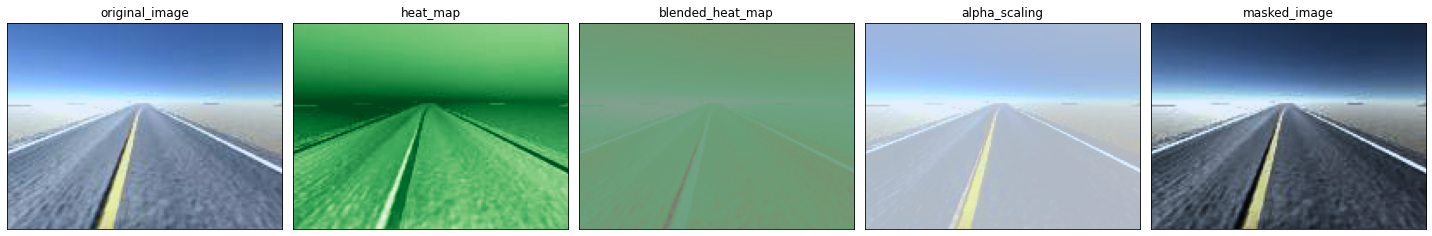

(<Figure size 1440x288 with 5 Axes>,
 array([<AxesSubplot:title={'center':'original_image'}>,
        <AxesSubplot:title={'center':'heat_map'}>,
        <AxesSubplot:title={'center':'blended_heat_map'}>,
        <AxesSubplot:title={'center':'alpha_scaling'}>,
        <AxesSubplot:title={'center':'masked_image'}>], dtype=object))

In [ ]:
#from the viewpoint of the model
from captum.attr._utils.visualization import *
methods = ["original_image","heat_map","blended_heat_map","alpha_scaling","masked_image"]
visualize_image_attr_multiple(img,
                              attr,
                              methods=methods,
                              titles=methods,
                              fig_size=(20,4),
                              signs=["positive"]*5)